# Notebook de modélisation
## Adrian Rodriguez
## Projet 5 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [2]:
import pandas as pd
pd.options.display.max_columns = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.model_selection import train_test_split

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")
import pyLDAvis.sklearn

from functions import *

import time
import pickle
import warnings
warnings.filterwarnings('ignore')

c:\Users\rodri\.vscode\extensions\ms-python.python-2020.8.108011\pythonFiles\lib\python\past\types\oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [3]:
start_notebook = time.time()

---
# 1. Importation et exploration préliminaire


In [4]:
questions_raw = pd.read_csv('src/cleaned_questions.csv')

In [5]:
questions_raw.head()

,Id,Tags,Title_Body,Cleaned_Title_Body
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...


In [6]:
questions_raw.shape

(49134, 4)

In [7]:
questions_raw.columns

Index(['Id', 'Tags', 'Title_Body', 'Cleaned_Title_Body'], dtype='object')

In [8]:
questions_raw.isna().sum()

Id                    0
Tags                  1
Title_Body            0
Cleaned_Title_Body    3
dtype: int64

In [9]:
questions_raw = questions_raw[questions_raw['Cleaned_Title_Body'].notna()]
questions_raw = questions_raw[questions_raw['Tags'].notna()]

In [10]:
questions = questions_raw.copy()

In [11]:
questions[questions.Cleaned_Title_Body.isna()]

,Id,Tags,Title_Body,Cleaned_Title_Body


In [12]:
# Je limite le nombre d'observation pour la phase de dev
questions = questions.head(10000)

# 2. Classification non supervisée avec LDA
Méthode : 
- 1/ Création du vecteur de mots
- 2/ Calcul du nombre de sujet idéal
- 3/ Formation du modèle
- 4/ Vérification des résultats

In [12]:
corpus = questions.Cleaned_Title_Body

## Création du vecteur de mots

In [13]:
count_vectorizer = CountVectorizer()
feature_matrix = count_vectorizer.fit_transform(corpus)
display(feature_matrix.shape)

(10000, 20338)

In [41]:
# Sauvegarde du vectoizer
pickle.dump(count_vectorizer, open('api/count_vectorizer.sav', 'wb'))

## Détermination du nombre de sujet idéal

In [14]:
results = pd.DataFrame()
tmp_result = pd.DataFrame(index = range(1))
for i in np.arange(5, 70, 5):
    print(f'{i} composants en cours de traitement...')
    lda_model = LatentDirichletAllocation(n_components=i, random_state=123)

    lda_model.fit_transform(feature_matrix)

    tmp_result['n_components'] = i
    tmp_result['log_likelihood'] = lda_model.score(feature_matrix)
    tmp_result['perplexity'] = lda_model.perplexity(feature_matrix)

    results = results.append(tmp_result)

results

5 composants en cours de traitement...
10 composants en cours de traitement...
15 composants en cours de traitement...
20 composants en cours de traitement...
25 composants en cours de traitement...
30 composants en cours de traitement...
35 composants en cours de traitement...
40 composants en cours de traitement...
45 composants en cours de traitement...
50 composants en cours de traitement...
55 composants en cours de traitement...
60 composants en cours de traitement...
65 composants en cours de traitement...


,n_components,log_likelihood,perplexity
0,5,-2.673089e+06,1808.303976
0,10,-2.672598e+06,1805.815236
0,15,-2.670089e+06,1793.146399
0,20,-2.667524e+06,1780.288853
0,25,-2.666966e+06,1777.501372
0,30,-2.669810e+06,1791.740879
0,35,-2.673958e+06,1812.719517
0,40,-2.676036e+06,1823.317794
0,45,-2.678189e+06,1834.367369
0,50,-2.683701e+06,1862.953475


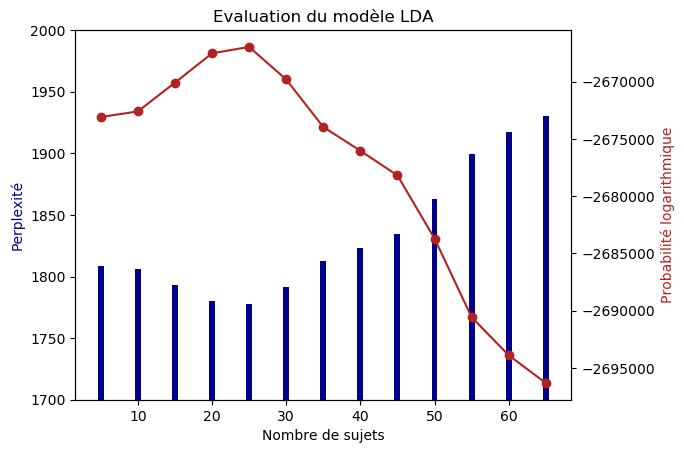

In [15]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(results.n_components,
        results.perplexity,
        color='darkblue')
ax2.plot(results.n_components,
         results.log_likelihood,
         'o-',
         color="firebrick")
min_y = int(results.perplexity.min()/100)*100
max_y = int((results.perplexity.max()+100)/100)*100
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('Nombre de sujets')
ax1.set_ylabel('Perplexité', color='darkblue')
ax2.set_ylabel('Probabilité logarithmique', color='firebrick')
plt.title('Evaluation du modèle LDA')
plt.savefig('img/img_LDA_evaluation.png',
            transparent=True)
plt.show()

Je cherche à avoir la probabilité logarithmique la plus élevée et une moindre perplexité.

## Formation du modèle

In [16]:
min_perp = results.perplexity.min()
n_comp = results[results.perplexity == min_perp].n_components.item()
print(f'Le nombre de sujet idéal est de {n_comp}')
# Je forme le modèle
lda = LatentDirichletAllocation(n_components=n_comp, random_state=123)
%time lda_out = lda.fit_transform(feature_matrix)

Le nombre de sujet idéal est de 25
Wall time: 42.8 s


In [17]:
# Temporaire : pour éviter de relancer le calcul à chaque essai
#lda = LatentDirichletAllocation(n_components=15, random_state=123)
# %time lda_out = lda.fit_transform(feature_matrix)

In [18]:
# Sauvegarde du modèle
pickle.dump(lda, open('api/unsupervised_model.sav', 'wb'))

In [19]:
# Sujet dominants dans chaque documents
doc_topic = get_doc_topic(lda, corpus, lda_out)
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14,Topic_#15,Topic_#16,Topic_#17,Topic_#18,Topic_#19,Topic_#20,Topic_#21,Topic_#22,Topic_#23,Topic_#24
0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.61,0.0,0.35,0.00,0.0
1,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.95,0.00,0.00,0.0,0.00,0.00,0.0
2,0.06,0.0,0.00,0.00,0.21,0.18,0.0,0.0,0.00,0.0,0.0,0.09,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.43,0.0
3,0.00,0.0,0.00,0.00,0.00,0.18,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.09,0.00,0.68,0.0,0.00,0.00,0.0
4,0.00,0.0,0.31,0.00,0.00,0.58,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.08,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.0,0.33,0.55,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.09,0.00,0.00,0.0,0.00,0.00,0.0
9996,0.00,0.0,0.26,0.00,0.00,0.00,0.0,0.0,0.52,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.15,0.00,0.0,0.00,0.00,0.0
9997,0.00,0.0,0.00,0.00,0.00,0.40,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.10,0.00,0.00,0.0,0.00,0.47,0.0
9998,0.00,0.0,0.00,0.00,0.00,0.00,0.1,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.10,0.00,0.78,0.0,0.00,0.00,0.0


<Figure size 640x480 with 0 Axes>

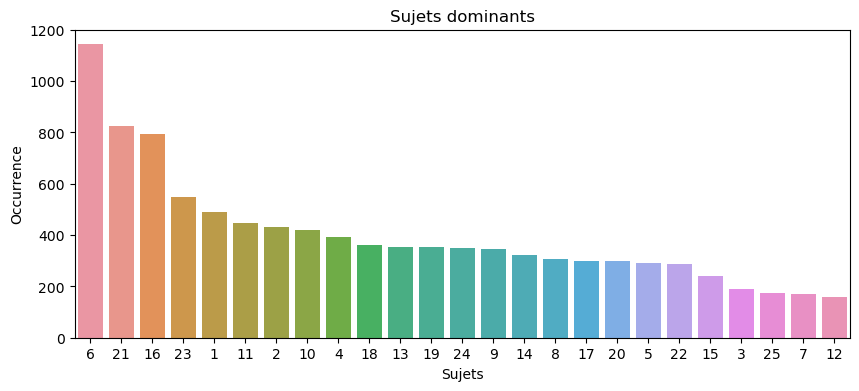

In [20]:
dominant_topic = doc_topic.copy()
dominant_topic['dominant_topic'] = np.argmax(dominant_topic.values, axis=1) + 1
order = dominant_topic.groupby('dominant_topic')['Topic_#1'].count().sort_values(ascending=False).index

plt.clf()
plt.figure(figsize=(10,4))
sns.countplot(dominant_topic.dominant_topic, order=order)
plt.title('Sujets dominants')
plt.xlabel('Sujets')
plt.ylabel('Occurrence')
plt.savefig('img/img_dominant_topic.png',
            transparent=True)

In [43]:
# Top mots clés des différents sujets.
topic_keywords = show_topics(count_vectorizer, lda, 5)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic_#' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv('api/topic_keyword.csv')
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic_#0,request,api,datum,firebase,http
Topic_#1,component,react,state,new,hook
Topic_#2,key,text,value,line,store
Topic_#3,string,number,code,function,character
Topic_#4,model,size,spring,file,datum
Topic_#5,error,file,project,xcode,version
Topic_#6,git,thread,memory,branch,password
Topic_#7,image,color,chrome,angular,browser
Topic_#8,app,page,native,react,user
Topic_#9,docker,container,command,error,image


In [22]:
panel = pyLDAvis.sklearn.prepare(lda, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'img/lda.html')
pyLDAvis.display(panel)

## Vérification des résultats
A partir des sujets dominants dans chaque documents et des 5 mots clés principaux de chaque sujets dominants, je constitue une suggestion de tags non supervisée.

In [23]:
pred_tag = get_unsupervised_tag(doc_topic, df_topic_keywords, corpus)
questions = pd.merge(questions, pred_tag, left_index=True, right_index=True)
questions

,Id,Tags,Title_Body,Cleaned_Title_Body,5,unsupervised_tag
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...,None,"code,function,compiler,class,method"
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...,None,"value,object,array,return,type"
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...,None,"model,error,column,table,row"
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...,None,"error,code,function,compiler,pointer"
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...,None,"key,text,error,file,project"
...,...,...,...,...,...,...
9995,46387760,"javascript,regex,validation",Match the same start and end character of a st...,match start end character string regex start e...,None,"key,text,string,number,code"
9996,46387355,react_native,text shadow in react native <p>in my site i ha...,text shadow react native site title text shado...,None,"key,app,page,native,python"
9997,46387262,"swift,xcode,xcode9,xcode10",Code Folding changes in Xcode 9/10 <p>I know c...,code change xcode know code folding early beta...,None,"error,file,value,column,table"
9998,46387111,"c,arrays,memory",How does the compiler allocate memory without ...,compiler allocate memory size compile time wri...,None,"value,code,function,compiler,pointer"


---
---

# Classification supervisée

In [13]:
corpus = questions.Cleaned_Title_Body
# Vectorisation des données
tfidf_vectorizer = TfidfVectorizer()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_matrix.shape

(10000, 20338)

In [14]:
tfidf_feature_matrix

<10000x20338 sparse matrix of type '<class 'numpy.float64'>'
	with 237811 stored elements in Compressed Sparse Row format>

In [31]:
import umap

mapper = umap.UMAP(n_components=1000, metric='jaccard', random_state=42)
%time umap_feature_matrix = mapper.fit_transform(tfidf_feature_matrix)

Wall time: 5min 40s


In [32]:
umap_feature_matrix.shape

(10000, 1000)

In [33]:
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
std_feature_matrix = scaler.fit_transform(tfidf_feature_matrix)
n_comp = int(tfidf_feature_matrix.shape[1] / 2)

from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=n_comp)
%time tsvd_feature_matrix = tsvd.fit_transform(std_feature_matrix)

var = tsvd.explained_variance_ratio_.cumsum()*100
var = pd.DataFrame(var, columns=['Variance cumulée']).reset_index()
var90 = var[var['Variance cumulée'] <= 90].tail(1).reset_index(drop=True)
n_comp = var90.at[0, 'index']
n_comp

fig, ax = plt.subplots()
sns.lineplot(x='index', y='Variance cumulée', data=var)
ax.axhline(y=90, linestyle='--', c="red")
ax.annotate('Seuil des 90% de variance expliquée', xy=(n_comp, 90), xytext=(4000, 70),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'))

tsvd = TruncatedSVD(n_components=n_comp)
%time tsvd_feature_matrix = tsvd.fit_transform(std_feature_matrix)
"""

'\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler(with_mean=False)\nstd_feature_matrix = scaler.fit_transform(tfidf_feature_matrix)\nn_comp = int(tfidf_feature_matrix.shape[1] / 2)\n\nfrom sklearn.decomposition import TruncatedSVD\ntsvd = TruncatedSVD(n_components=n_comp)\n%time tsvd_feature_matrix = tsvd.fit_transform(std_feature_matrix)\n\nvar = tsvd.explained_variance_ratio_.cumsum()*100\nvar = pd.DataFrame(var, columns=[\'Variance cumulée\']).reset_index()\nvar90 = var[var[\'Variance cumulée\'] <= 90].tail(1).reset_index(drop=True)\nn_comp = var90.at[0, \'index\']\nn_comp\n\nfig, ax = plt.subplots()\nsns.lineplot(x=\'index\', y=\'Variance cumulée\', data=var)\nax.axhline(y=90, linestyle=\'--\', c="red")\nax.annotate(\'Seuil des 90% de variance expliquée\', xy=(n_comp, 90), xytext=(4000, 70),arrowprops=dict(arrowstyle=\'->\',connectionstyle=\'arc3,rad=-.2\'))\n\ntsvd = TruncatedSVD(n_components=n_comp)\n%time tsvd_feature_matrix = tsvd.fit_transform(std_fe

In [34]:
# Vectorisation des targets
mlb = MultiLabelBinarizer()
target = questions.Tags
target = [set(i.split(',')) for i in target]
target = mlb.fit_transform(target)
target.shape

(10000, 920)

In [35]:
# Sauvegarde du vectoizer
pickle.dump(tfidf_vectorizer, open('api/tfidf_vectorizer.sav', 'wb'))
# Sauvegarde du binarizer
pickle.dump(mlb, open('api/binarizer.sav', 'wb'))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(umap_feature_matrix, target, test_size=0.2, random_state=123)

In [37]:
classifiers = [('LogisticRegression',
                LogisticRegression(penalty='l1', solver='liblinear'),
                [{'estimator__C': [10]}])]

%time evaluate_classifier(X_train, X_test, y_train, y_test, classifiers, cv=3)

LogisticRegression en cours d'exécution...


---

In [33]:
classifiers = [('LogisticRegression',
                LogisticRegression(penalty='l1', solver='liblinear'),
                [{'estimator__C': [1, 10]}]),

              ('LinearSVC',
               LinearSVC(penalty='l1', dual=False),
               [{'estimator__C': [1, 10]}]), 

              ('SGD',
               SGDClassifier(penalty='l1'),
               [{'estimator__alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'estimator__n_estimators': [100, 200]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'estimator__n_estimators': [100, 200]}])]

%time evaluate_classifier(X_train, X_test, y_train, y_test, classifiers, cv=3)

LogisticRegression en cours d'exécution...


Wall time: 15.2 s
Wall time: 93.8 ms


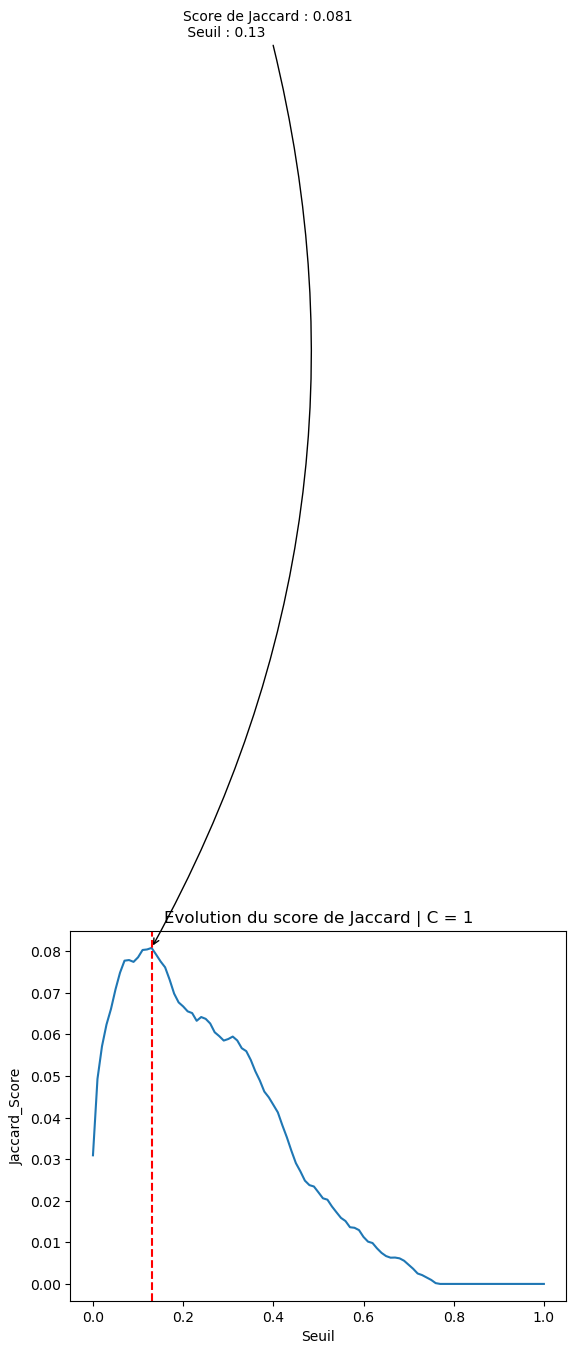

Wall time: 21 s
Wall time: 122 ms


<Figure size 640x480 with 0 Axes>

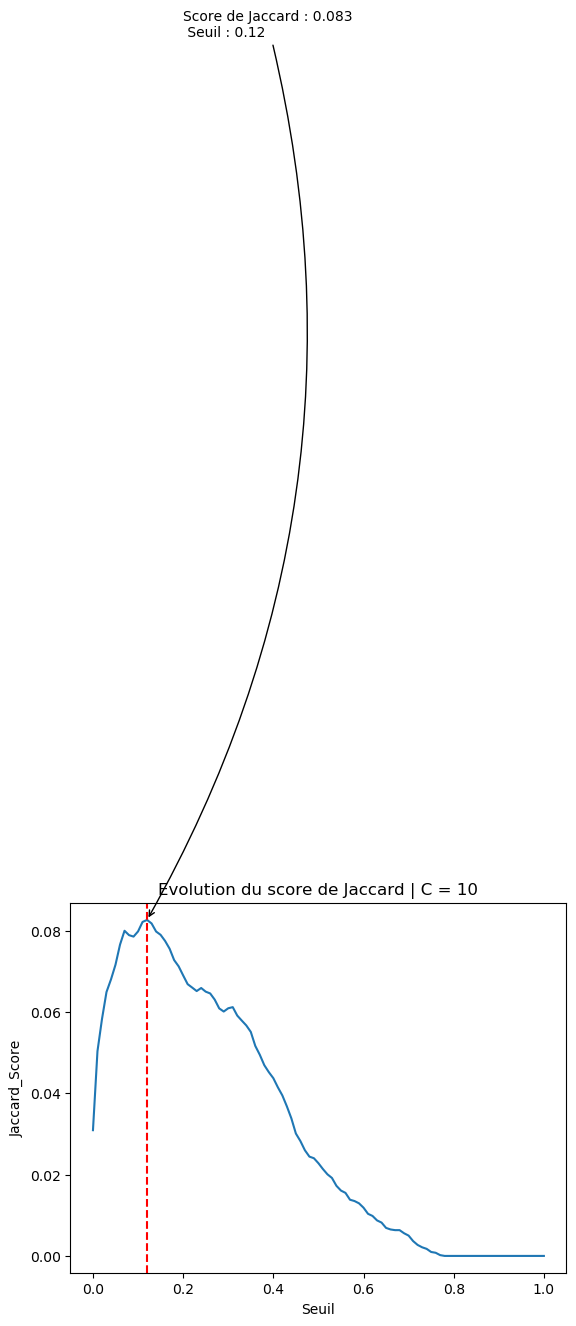

<Figure size 640x480 with 0 Axes>

In [23]:
# Recherche du meilleur seuil de la régression logistique
for c in [1, 10]:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    model = OneVsRestClassifier(model)
    %time model.fit(X_train, y_train)
    %time y_pred = model.predict_proba(X_test)

    tresh = {}
    for i in np.arange(0, 1.01, 0.01):
        y_pred_tres = pd.DataFrame(y_pred).applymap(lambda x: 1 if x > i else 0)
        tresh[i] = jaccard_score(y_test, y_pred_tres, average='weighted')
    
    df_tresh = pd.DataFrame.from_dict(tresh, orient='index').reset_index()
    df_tresh = df_tresh.rename(columns={'index': 'Seuil', 0: 'Jaccard_Score'})
    best_tresh = df_tresh.sort_values(by='Jaccard_Score', ascending=False).iloc[0].Seuil
    best_jacc = df_tresh.sort_values(by='Jaccard_Score', ascending=False).iloc[0].Jaccard_Score

    fig, ax = plt.subplots()
    sns.lineplot(x='Seuil', y='Jaccard_Score', data=df_tresh)
    ax.axvline(x=best_tresh, linestyle='--', color='red')
    text = 'Score de Jaccard : ' + str(round(best_jacc,3)) + '\n Seuil : ' + str(best_tresh)
    ax.annotate(text, xy=(best_tresh, best_jacc), xytext=(0.2, 0.3),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'))
    plt.title('Evolution du score de Jaccard | C = ' + str(c))
    plt.savefig('img/img_evolution_jaccard_C' + str(c) + '.png',
                transparent=True)
    plt.show()
    plt.clf()

In [ ]:
# Sauvegarde du modèle
pickle.dump(model, open('api/supervised_model.sav', 'wb'))

## Vérification

In [30]:
y_pred_tres = pd.DataFrame(y_pred).applymap(lambda x: 1 if x > best_tresh else 0)

# Je convertis le dataframe en array
y_pred_tres = y_pred_tres.to_numpy()

# Je récupère les nom des tags prédits, les tags originaux ainsi que les textes nettoyés originaux
sup_pred = transform_tuple(mlb.inverse_transform(y_pred_tres))
tag = transform_tuple(mlb.inverse_transform(y_test))
text = transform_tuple(tfidf_vectorizer.inverse_transform(umap.inverse_transform(X_test)))

# J'assemble le tout dans un dataframe pour une meilleure comparaison
df_text = pd.DataFrame(text, columns=['original_text_cleaned']).original_text_cleaned.str.replace(',', ' ')
df_tag = pd.DataFrame(tag, columns=['original_tags'])
df_sup_pred = pd.DataFrame(sup_pred, columns=['supervised_pred'])

results_tmp = pd.merge(df_text, df_tag, left_index=True, right_index=True)
results = pd.merge(results_tmp, df_sup_pred, left_index=True, right_index=True)
results.head(20)

,original_text_cleaned,original_tags,supervised_pred
0,and android area case certain contentcontainer...,"react_native,reactjs","ios,javascript,react_native,react_native_android"
1,2nd apii aspnetcore boolean context core cycle...,"asp.net_core,c#,entity_framework_core",
2,basic clear declare googling implication infor...,"angular,tslint,typescript",tslint
3,address argument cast character class code com...,"c#,lambda","c++,lambda"
4,automatic button color different figure head s...,flutter,"flutter,html"
5,angular budget budgets build chunk detail exac...,"angular,build","angular,ionic3,typescript"
6,es6 file have javascript js module node part p...,"javascript,node.js,typescript","ecmascript_6,javascript,node.js,typescript"
7,20th 28th 9999999999999999999999999999 activit...,".net_core,c#,powershell",
8,error fail find installation mongod mongodb se...,"mongodb,ubuntu,ubuntu_16.04",mongodb
9,class curious duration flexibility instead lik...,"java,java_time","c++,javascript"


In [31]:
# Récurrence des tags sur l'échantillon de test
tags = df_tag.original_tags.str.split(',').explode().reset_index()
tags = tags.groupby('original_tags').count().sort_values(by='index', ascending=False).reset_index().rename(columns={'index': 'recurrence'})
tags

,original_tags,recurrence
0,android,216
1,python,213
2,javascript,188
3,c++,183
4,angular,146
...,...,...
684,javafx,1
685,java_module,1
686,jasmine,1
687,iterator,1


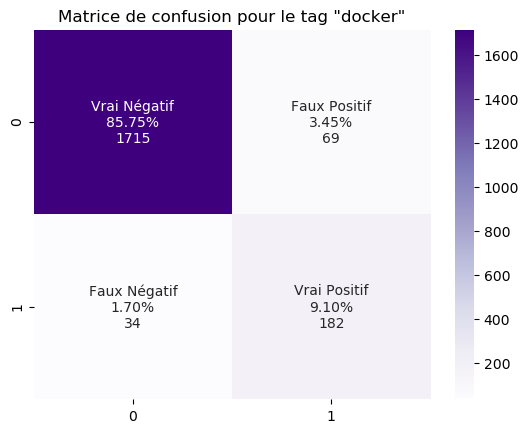

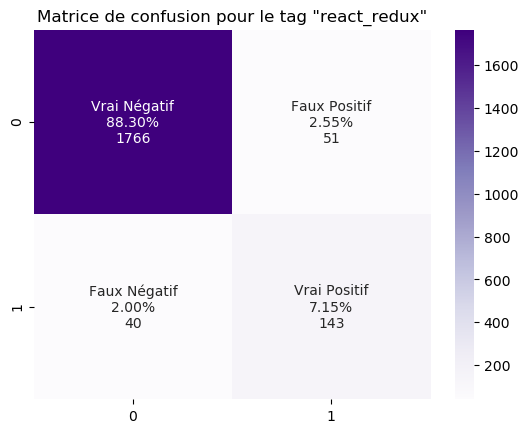

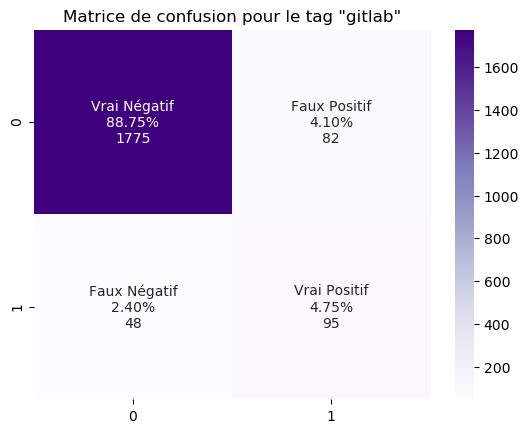

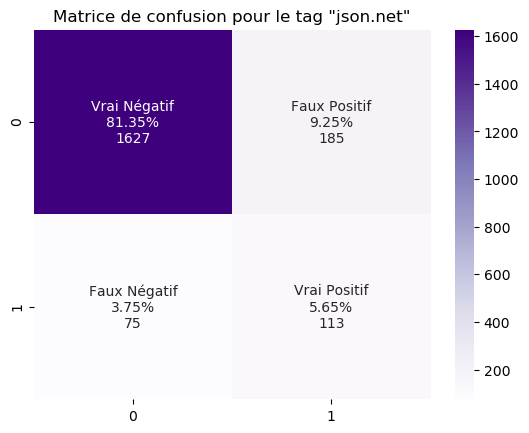

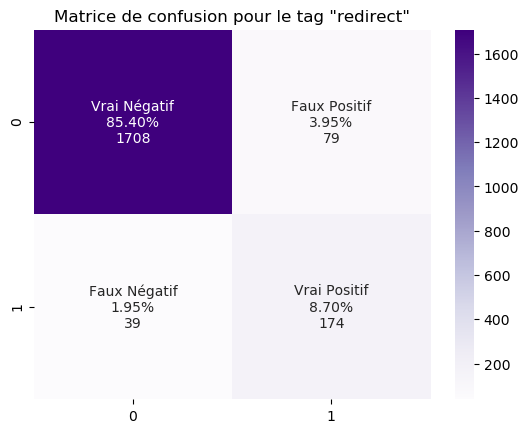

<Figure size 640x480 with 0 Axes>

In [32]:
# Recherche des tags les moins performants (vrais négatif inférieur à 90 %)
from sklearn.metrics import confusion_matrix

for i in range(len(tags)):
    n_tag = i
    cf_matrix = confusion_matrix(y_test[:, n_tag], y_pred_tres[:, n_tag])
    if cf_matrix[0][0] < 1800:
        # cf_matrix = np.array([[2000, 0], [0, 0]])

        name = ['Vrai Négatif', 'Faux Positif', 'Faux Négatif', 'Vrai Positif']
        percent = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(name, percent, counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')
        loc = np.where(mlb.classes_ == tags.original_tags[n_tag])

        plt.title('Matrice de confusion pour le tag "' + mlb.classes_[loc][0] + '"')
        plt.show()
        plt.clf()

Le tag le moins performant est json.net

In [33]:
end_notebook = time.time()
exec_time(start_notebook, end_notebook)

'07:17:00'

# Version des packages

In [35]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import nltk; print("NLTK", nltk.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)
import gensim; print("gensim", gensim.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy 1.19.1
Pandas 1.0.3
Seaborn 0.10.0
Matplotlib 3.1.3
NLTK 3.5
requests 2.24.0
BeautifulSoup 4.8.2
re 2.2.1
spacy 2.3.2
gensim 3.8.0
